In [8]:
import os
import sys
sys.path.insert(0, os.path.abspath('../../cvxportfolio'))

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxportfolio as cp

plotdir = 'plots/'
datadir='data/'

sigmas=pd.read_csv(datadir+'sigmas.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]
returns=pd.read_csv(datadir+'returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]



#, 'NKE', 'IBM', 'BAC', 'C'
subset_tickers = ['AMZN', 'GOOGL', 'BAC', 'USDOLLAR']
sigmas = sigmas.ix[:, sigmas.columns.isin(subset_tickers)]
returns = returns.ix[:, returns.columns.isin(subset_tickers)]
volumes = volumes.ix[:, volumes.columns.isin(subset_tickers)]

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

start_t="2012-02-01"
end_t="2016-12-29"

simulated_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., sigma=sigmas, volume=volumes)
simulated_hcost = cp.HcostModel(borrow_costs=0.0001)
simulator = cp.MarketSimulator(returns, costs=[simulated_tcost, simulated_hcost],
                               market_volumes=volumes, cash_key='USDOLLAR')

return_estimate=pd.read_csv(datadir+'return_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()
volume_estimate=pd.read_csv(datadir+'volume_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()
sigma_estimate=pd.read_csv(datadir+'sigma_estimate.csv.gz',index_col=0,parse_dates=[0]).dropna()

return_estimate = return_estimate.ix[:, return_estimate.columns.isin(subset_tickers)]
volume_estimate = volume_estimate.ix[:, volume_estimate.columns.isin(subset_tickers)]
sigma_estimate = sigma_estimate.ix[:, sigma_estimate.columns.isin(subset_tickers)]

optimization_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., 
                                sigma=sigma_estimate, volume=volume_estimate)
optimization_hcost=cp.HcostModel(borrow_costs=0.0001)

Sigma_hat = returns.rolling(window=250, min_periods=250).cov().unstack().shift(1).stack().dropna()
#risk_data = pd.HDFStore(datadir+'risk_model.h5')
#risk_model = cp.FactorModelSigma(risk_data.exposures, risk_data.factor_sigma, risk_data.idyos)
risk_model = cp.FullSigma(Sigma_hat)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for 

In [10]:
all_return_estimates={}
n_p1=returns.shape[1]
T=returns.shape[0]

for i,t in enumerate(returns.index[:-1]):
    all_return_estimates[(t,t)]= return_estimate.loc[t]
    tp1=returns.index[i+1]
    all_return_estimates[(t,tp1)]=return_estimate.loc[tp1]
    
returns_forecast = cp.MPOReturnsForecast(all_return_estimates)
results_MPO={}

## MPO Coarse search 

In [ ]:
policies={}
gamma_risks_coarse=[.1,.3,1, 3,10,30,100,300,1000]
gamma_tcosts_coarse=[1., 2., 5,10,20]
for gamma_risk in gamma_risks_coarse:
    for gamma_tcost in gamma_tcosts_coarse: 
        policies[(gamma_risk, gamma_tcost)] = \
      cp.MultiPeriodOpt(return_forecast=returns_forecast, 
                          costs=[gamma_risk*risk_model, gamma_tcost*optimization_tcost, optimization_hcost], 
                          constraints=[cp.LeverageLimit(3)],
                          trading_times=list(returns.index),#[(returns.index>=start_t)&(returns.index<=end_t)]),
                         lookahead_periods=2,
                         terminal_weights=None)

results_MPO.update({k:v for k,v in zip(policies.keys(),
                           simulator.run_multiple_backtest(w_b*1e8, start_time = start_t, end_time=end_t, 
                                          policies=policies.values(),parallel=False))})

In [ ]:
result_df_coarse=pd.DataFrame()
for k in results_MPO:
    if k[0] in gamma_risks_coarse and k[1] in gamma_tcosts_coarse:
        result_df_coarse.loc[k[0], k[1]] = results_MPO[k]
        
result_df = result_df_coarse.loc[sorted(result_df_coarse.index), sorted(result_df_coarse.columns)]

In [ ]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier.png')

### Fine search

In [7]:
policies = {}

gamma_risks_fine=gamma_risks_coarse
gamma_tcosts_fine=[4,5,6,7,8]
for gamma_risk in gamma_risks_fine:
    for gamma_tcost in gamma_tcosts_fine: 
        policies[(gamma_risk, gamma_tcost)] = \
      cp.MultiPeriodOpt(return_forecast=returns_forecast, 
                          costs=[gamma_risk*risk_model, gamma_tcost*optimization_tcost, optimization_hcost], 
                          constraints=[cp.LeverageLimit(3)],
                          trading_times=list(returns.index),#[(returns.index>=start_t)&(returns.index<=end_t)]),
                         lookahead_periods=2,
                         terminal_weights=None)

results_MPO.update({k:v for k,v in zip(policies.keys(),
                           simulator.run_multiple_backtest(w_b*1e8, start_time = start_t, end_time=end_t, 
                                          policies=policies.values(),parallel=True))})

In [8]:
result_df_fine=pd.DataFrame()
for k in results_MPO:
    if k[0] in gamma_risks_fine and k[1] in gamma_tcosts_fine:
        result_df_fine.loc[k[0], k[1]] = results_MPO[k]
        
result_df = result_df_fine.loc[sorted(result_df_fine.index), sorted(result_df_fine.columns)]

[22.663224644589217, 21.257008318354387, 18.350339679236086, 12.856100893431098, 6.1234272044906843, 2.6848246593987111, 1.2671018770085236, 0.76648463665630917, 0.5456767282326288] [73.74943504686986, 66.88252572876938, 51.46845660924953, 32.846898766279814, 12.556923455910672, 3.375982637229158, 0.726544021445654, -0.06183267732054507, -0.5153149656780649]
[20.340775861369469, 18.899145322106708, 15.915948951903777, 10.999069404773916, 5.8732709098717404, 2.8410086329985957, 1.3392896773823346, 0.80529865913671883, 0.56287218783884152] [59.46459070370852, 55.755138360034486, 45.52307678373141, 28.14080204191203, 10.853086415272047, 2.6830605015085767, 0.014264061234031088, -0.3895936621073465, -0.6222061509406398]
[19.079861264372173, 17.734399506555437, 14.935738021784008, 10.368560995788442, 5.614046883560869, 2.9610577716699567, 1.4313209596875047, 0.84559738702615106, 0.58000544213075667] [52.749031328569295, 50.21556794137098, 42.81045638033025, 27.249612622996647, 9.38357183028

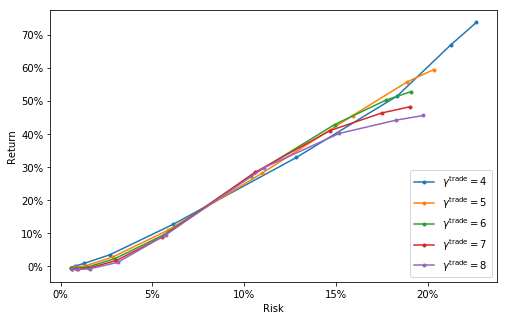

In [9]:
plt.figure(figsize=(8,5))
for gamma_tcost in result_df.columns:
    x=[el.excess_returns.std()*100*np.sqrt(250) for el in result_df[gamma_tcost]]
    y=[el.excess_returns.mean()*100*250 for el in result_df[gamma_tcost]]
    print(x,y)
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'spo_riskrewardfrontier.png')

# MPO Pareto search 

In [10]:
results_pareto={}

In [11]:
policies={}
#gamma_risks_pareto=[int(round(el)) for el in np.logspace(0,3,13)]
gamma_risks_pareto=[1, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000]
gamma_tcosts_pareto=[7,8,9,10,11,12]
gamma_holdings=[.1,1.,10., 100.,1000.]
for gamma_risk in gamma_risks_pareto:
    for gamma_tcost in gamma_tcosts_pareto : 
        for gamma_holding in gamma_holdings:
            policies[(gamma_risk, gamma_tcost, gamma_holding)] = cp.MultiPeriodOpt(
                return_forecast=returns_forecast, 
                          costs=[gamma_risk*risk_model, gamma_tcost*optimization_tcost, 
                                 gamma_holding*optimization_hcost], 
                          constraints=[cp.LeverageLimit(3)],
                          trading_times=list(returns.index),#[(returns.index>=start_t)&(returns.index<=end_t)]),
#                          trading_times=list(returns.index[(returns.index>=start_t)&(returns.index<=end_t)]),
                         lookahead_periods=2,
                         terminal_weights=None)

import warnings
warnings.filterwarnings('ignore')
results_pareto.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,
                                                                                end_time=end_t,
                                              policies=policies.values(), parallel=True))))

In [13]:
table=pd.DataFrame()
table[r'$\gamma^\mathrm{risk}$']=[el[0] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{trade}$']=[el[1] for el in results_pareto.keys()]
table[r'$\gamma^\mathrm{hold}$']=['%g'%el[2] for el in results_pareto.keys()]
table['Return']=[(results_pareto[k].excess_returns.mean()*100*250) for k in results_pareto.keys()]
table['Risk']=[(results_pareto[k].excess_returns.std()*100*np.sqrt(250)) for k in results_pareto.keys()]

table = table.sort_values('Risk', ascending=False).reset_index()
del table['index']
is_pareto = lambda i: table.loc[i,'Return']>=max(table.ix[i:].Return)
table['is_pareto'] = [is_pareto(i) for i in range(len(table))]
table.to_csv(datadir+'mpo_pareto_results.csv', float_format='%g')

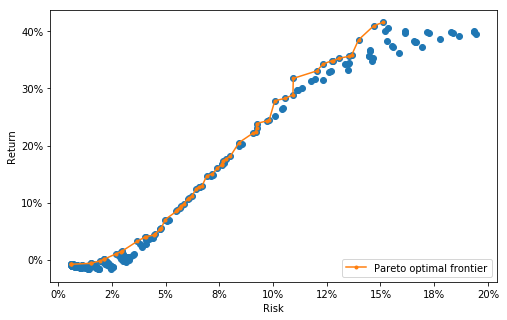

In [14]:
plt.figure(figsize=(8,5))
plt.scatter(table.Risk.values,table.Return.values)
plt.plot(table[table.is_pareto].Risk,table[table.is_pareto].Return, 'C1.-', label='Pareto optimal frontier')
plt.legend( loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

#plt.savefig(plotdir+'mpo_pareto.png')

In [15]:
xlim=20
ylim=30
tableprint=table[table.is_pareto]
tableprint=tableprint[tableprint.Risk <= xlim]
tableprint=tableprint[tableprint.Return <= ylim]
del tableprint['is_pareto']
tableprint.Risk=tableprint.Risk.apply(lambda x: '%.2f%%'%x)
tableprint.Return=tableprint.Return.apply(lambda x: '%.2f%%'%x)
print(tableprint.iloc[::-1].to_latex(float_format='%.2f', escape=False, index=False).replace('%',r'\%'))

\begin{tabular}{rrlll}
\toprule
 $\gamma^\mathrm{risk}$ &  $\gamma^\mathrm{trade}$ & $\gamma^\mathrm{hold}$ &  Return &    Risk \\
\midrule
                   1000 &                        7 &                     10 &  -0.83\% &   0.59\% \\
                   1000 &                        7 &                      1 &  -0.82\% &   0.60\% \\
                   1000 &                        7 &                    0.1 &  -0.82\% &   0.60\% \\
                    100 &                        7 &                      1 &  -0.66\% &   1.53\% \\
                    100 &                        7 &                    0.1 &  -0.63\% &   1.54\% \\
                     56 &                        7 &                     10 &  -0.23\% &   1.96\% \\
                     56 &                        7 &                      1 &   0.06\% &   2.13\% \\
                     56 &                        7 &                    0.1 &   0.08\% &   2.15\% \\
                     32 &                        7 &

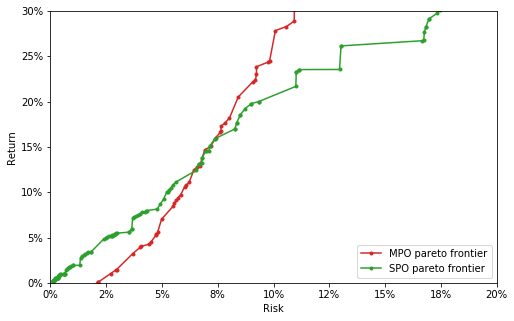

In [21]:
table_spo = pd.read_csv('data/spo_pareto_results_old.csv', index_col=0)

plt.figure(figsize=(8,5))

plt.plot(table[table.is_pareto].Risk, table[table.is_pareto].Return, 'C3.-', label='MPO pareto frontier')

plt.plot(table_spo[table_spo.is_pareto].Risk,
         table_spo[table_spo.is_pareto].Return, 'C2.-', label='SPO pareto frontier')
plt.legend(loc='lower right')
plt.xlabel('Risk')
plt.ylabel('Return')
plt.xlim([0,20])
plt.ylim([0,30])

import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

In [ ]:
table_spo = pd.read_csv('spo_pareto_results.csv', index_col=0),
    "plt.figure(figsize=(8,5))\n",
    "\n",
    "plt.plot(table[table.is_pareto].Risk,table[table.is_pareto].Return, 'C3.-', label='MPO pareto frontier')\n",
    "plt.plot(table_spo[table_spo.is_pareto].Risk,\n",
    "         table_spo[table_spo.is_pareto].Return, 'C2.-', label='SPO pareto frontier')\n",
    "plt.legend(loc='lower right')\n",
    "plt.xlabel('Risk')\n",
    "plt.ylabel('Return')\n",
    "plt.xlim([0,20])\n",
    "plt.ylim([0,30])\n",
    "\n",
    "import matplotlib.ticker as mtick\n",
    "ax = plt.gca()\n",
    "ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))\n",
    "ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))\n",
    "\n",
    "\n",
    "plt.savefig(plotdir+'spo_vs_mpo_pareto.png')"

In [16]:
table

,$\gamma^\mathrm{risk}$,$\gamma^\mathrm{trade}$,$\gamma^\mathrm{hold}$,Return,Risk,is_pareto
0,1,12,10,39.519409,19.458920,False
1,1,12,1,39.936708,19.351095,False
2,1,12,0.1,39.989826,19.330859,False
3,1,11,10,39.190911,18.673461,False
4,1,11,1,39.752673,18.359272,False
5,1,11,0.1,39.913923,18.290582,False
6,1,10,10,38.644918,17.766133,False
7,1,10,1,39.673369,17.256078,False
8,1,10,0.1,39.901530,17.184588,False
9,2,12,10,37.353786,16.913477,False
